In [3]:
import torch

In [4]:
loras = torch.load('/workspace/Weight_compression/text-to-lora/target_loras.pt')

In [10]:
blob = loras

In [24]:
import os, re, math
import torch
import numpy as np
import matplotlib.pyplot as plt

# PT_PATH = "/workspace/Weight_compression/text-to-lora/target_loras.pt"  # 수정 가능
OUT_DIR = "./lora_rel_plots"
os.makedirs(OUT_DIR, exist_ok=True)

# blob = torch.load(PT_PATH, map_location="cpu")
target_loras = blob["target_loras"]
tasks = sorted(list(target_loras.keys()))
print(f"#tasks = {len(tasks)}  (예: {tasks[:5]} ...)")

# 2) 공통 모듈 추출 (A/B 둘 다 있는 모듈만)
def get_module_base(k: str):
    if k.endswith(".lora_A.weight"):
        return k[: -len(".lora_A.weight")]
    if k.endswith(".lora_B.weight"):
        return k[: -len(".lora_B.weight")]
    return None

# 모든 태스크의 키 수집
per_task_modules = []
for t in tasks:
    sd = target_loras[t]
    bases = set()
    keys = sd.keys() if isinstance(sd, dict) else sd.keys()
    for k in keys:
        base = get_module_base(k)
        if base is not None:
            bases.add(base)
    per_task_modules.append(bases)

# 공통 교집합
common_bases = set.intersection(*per_task_modules) if per_task_modules else set()

# A/B 둘 다 존재하는 모듈만 필터링
def has_A_B(sd, base):
    return (base + ".lora_A.weight" in sd) and (base + ".lora_B.weight" in sd)

filtered_bases = []
for base in sorted(common_bases):
    if all(has_A_B(target_loras[t], base) for t in tasks):
        filtered_bases.append(base)

print(f"#modules (A&B present in all tasks) = {len(filtered_bases)}")
if len(filtered_bases) == 0:
    raise RuntimeError("공통 모듈이 없습니다. 저장한 pt를 확인하세요.")

# === 유틸: 한 모듈에 대해 태스크별 LoRA A, B 벡터/Norm/코사인 행렬 계산 ===
def module_task_vectors_AB(base, tasks):
    """태스크별로 LoRA A, B를 따로 리턴"""
    vecs_A, vecs_B = [], []
    for t in tasks:
        sd = target_loras[t]
        A = sd[base + ".lora_A.weight"].detach().cpu().float().reshape(-1)
        B = sd[base + ".lora_B.weight"].detach().cpu().float().reshape(-1)
        vecs_A.append(A)
        vecs_B.append(B)
    return vecs_A, vecs_B

def l2_norms(vecs):
    return torch.stack([v.norm(p=2) for v in vecs]).numpy()

def cosine_matrix(vecs):
    X = torch.stack(vecs)  # [T, D]
    Xn = X / (X.norm(dim=1, keepdim=True) + 1e-12)
    return (Xn @ Xn.T).numpy()

def upper_mean_excl_diag(M):  # torch.Tensor [T,T]
    T = M.shape[0]
    if T <= 1:
        return float("nan")
    iu = torch.triu_indices(T, T, offset=1)
    vals = M[iu[0], iu[1]]
    return vals.mean().item()

def plot_module_AB(base, tasks, max_label=40):
    vecs_A, vecs_B = module_task_vectors_AB(base, tasks)
    norms_A, norms_B = l2_norms(vecs_A), l2_norms(vecs_B)
    C_A, C_B = cosine_matrix(vecs_A), cosine_matrix(vecs_B)

    # --- Norm 막대그래프 (A vs B) ---
    fig, axes = plt.subplots(1, 2, figsize=(max(8, min(20, len(tasks)*0.3)), 4.5))
    for ax, norms, tag in zip(axes, [norms_A, norms_B], ["A", "B"]):
        ax.bar(np.arange(len(tasks)), norms)
        ax.set_title(f"[Norm {tag}] {base}")
        if len(tasks) <= max_label:
            ax.set_xticks(np.arange(len(tasks)))
            ax.set_xticklabels(tasks, rotation=90)
        else:
            step = math.ceil(len(tasks)/max_label)
            xticks = np.arange(0, len(tasks), step)
            ax.set_xticks(xticks)
            ax.set_xticklabels([tasks[i] for i in xticks], rotation=90)
        ax.set_ylabel("||ΔW||₂")
    plt.tight_layout()
    plt.show()

    # --- Cosine Similarity 히트맵 (A vs B) ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax, C, tag in zip(axes, [C_A, C_B], ["A", "B"]):
        im = ax.imshow(C, aspect="auto", interpolation="nearest")
        ax.set_title(f"[Cosine {tag}] {base}")
        if len(tasks) <= 30:
            ax.set_xticks(np.arange(len(tasks)))
            ax.set_xticklabels(tasks, rotation=90, fontsize=7)
            ax.set_yticks(np.arange(len(tasks)))
            ax.set_yticklabels(tasks, fontsize=7)
        else:
            ax.set_xticks([]); ax.set_yticks([])
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def compute_module_pairwise_means(tasks, bases, sort_by="avg"):  # sort_by in {"A","B","avg",None}
    mods, meanA, meanB = [], [], []
    for base in bases:
        XA, XB = module_task_vectors_AB(base, tasks)  # [T,D]
        CA, CB = cosine_matrix(XA), cosine_matrix(XB) # [T,T]
        mA, mB = upper_mean_excl_diag(CA), upper_mean_excl_diag(CB)
        mods.append(base); meanA.append(mA); meanB.append(mB)
    return mods, meanA, meanB

def compute_module_norm_means(tasks, bases, sort_by="avg"):
    mods, meanA, meanB = [], [], []
    for base in bases:
        vals_A, vals_B = [], []
        for t in tasks:
            sd = target_loras[t]
            A = sd[base + ".lora_A.weight"].detach().cpu().float().reshape(-1)
            B = sd[base + ".lora_B.weight"].detach().cpu().float().reshape(-1)
            vals_A.append(A.norm(p=2).item())
            vals_B.append(B.norm(p=2).item())
        mods.append(base)
        meanA.append(np.mean(vals_A))
        meanB.append(np.mean(vals_B))
    return mods, meanA, meanB

def plot_module_pairwise_means_AB(tasks, bases, max_label=40, sort_by="avg", title_suffix=""):
    mods, meanA, meanB = compute_module_pairwise_means(tasks, bases, sort_by=sort_by)
    n = len(mods)
    x = np.arange(n)
    w = 0.45

    plt.figure(figsize=(max(8, min(24, n*0.35)), 5))
    plt.bar(x - w/2, meanA, width=w, label="A")
    plt.bar(x + w/2, meanB, width=w, label="B")
    plt.ylabel("Mean pairwise cosine (off-diagonal)")
    plt.title(f"LoRA Pairwise Mean Similarity per Module {title_suffix}".strip())
    if n <= max_label:
        plt.xticks(x, mods, rotation=90, fontsize=8)
    else:
        step = math.ceil(n / max_label)
        idxs = np.arange(0, n, step)
        plt.xticks(idxs, [mods[i] for i in idxs], rotation=90, fontsize=8)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def plot_module_norm_means_AB(tasks, bases, max_label=40, sort_by="avg", title_suffix=""):
    mods, meanA, meanB = compute_module_norm_means(tasks, bases, sort_by=sort_by)
    n = len(mods)
    x = np.arange(n)
    w = 0.45

    plt.figure(figsize=(max(8, min(24, n*0.35)), 5))
    plt.bar(x - w/2, meanA, width=w, label="A")
    plt.bar(x + w/2, meanB, width=w, label="B")
    plt.ylabel("Mean ||ΔW||₂ across tasks")
    plt.title(f"LoRA Norm Mean per Module {title_suffix}".strip())
    if n <= max_label:
        plt.xticks(x, mods, rotation=90, fontsize=8)
    else:
        step = math.ceil(n / max_label)
        idxs = np.arange(0, n, step)
        plt.xticks(idxs, [mods[i] for i in idxs], rotation=90, fontsize=8)
    plt.legend()
    plt.tight_layout()
    plt.show()


#tasks = 479  (예: ['lol_022', 'lol_043', 'lol_044', 'lol_045', 'lol_047'] ...)
#modules (A&B present in all tasks) = 64


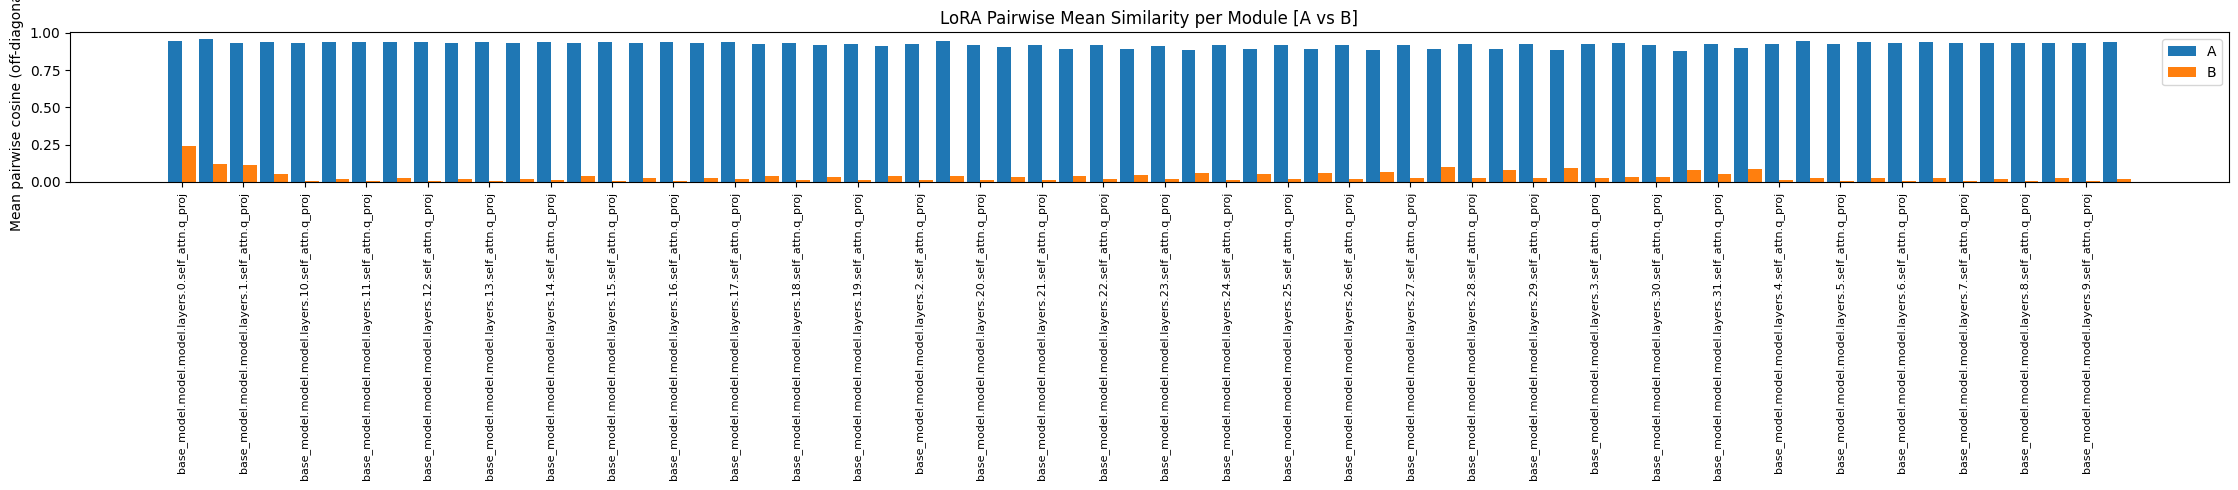

In [18]:
# 5) 사용 예시
# # 사용 가능한 모듈 목록 확인
# print("예시 모듈 5개:", filtered_bases[:5])

# # (A) 첫 번째 모듈 플롯
# module_name = filtered_bases[0]
# plot_module_AB(module_name, tasks)

# (B) 특정 모듈을 직접 지정하고 싶다면:
# module_name = "base_model.model.model.layers.0.self_attn.q_proj"
# plot_module(module_name, tasks)

# (C) 규칙에 맞는 여러 모듈을 일괄 저장하고 싶다면(시간 소요):
# pattern = re.compile(r"\.self_attn\.q_proj$")  # 예: q_proj만
# for base in filtered_bases:
#     if pattern.search(base):
#         plot_module(base, tasks)
plot_module_pairwise_means_AB(tasks, filtered_bases, title_suffix="[A vs B]")

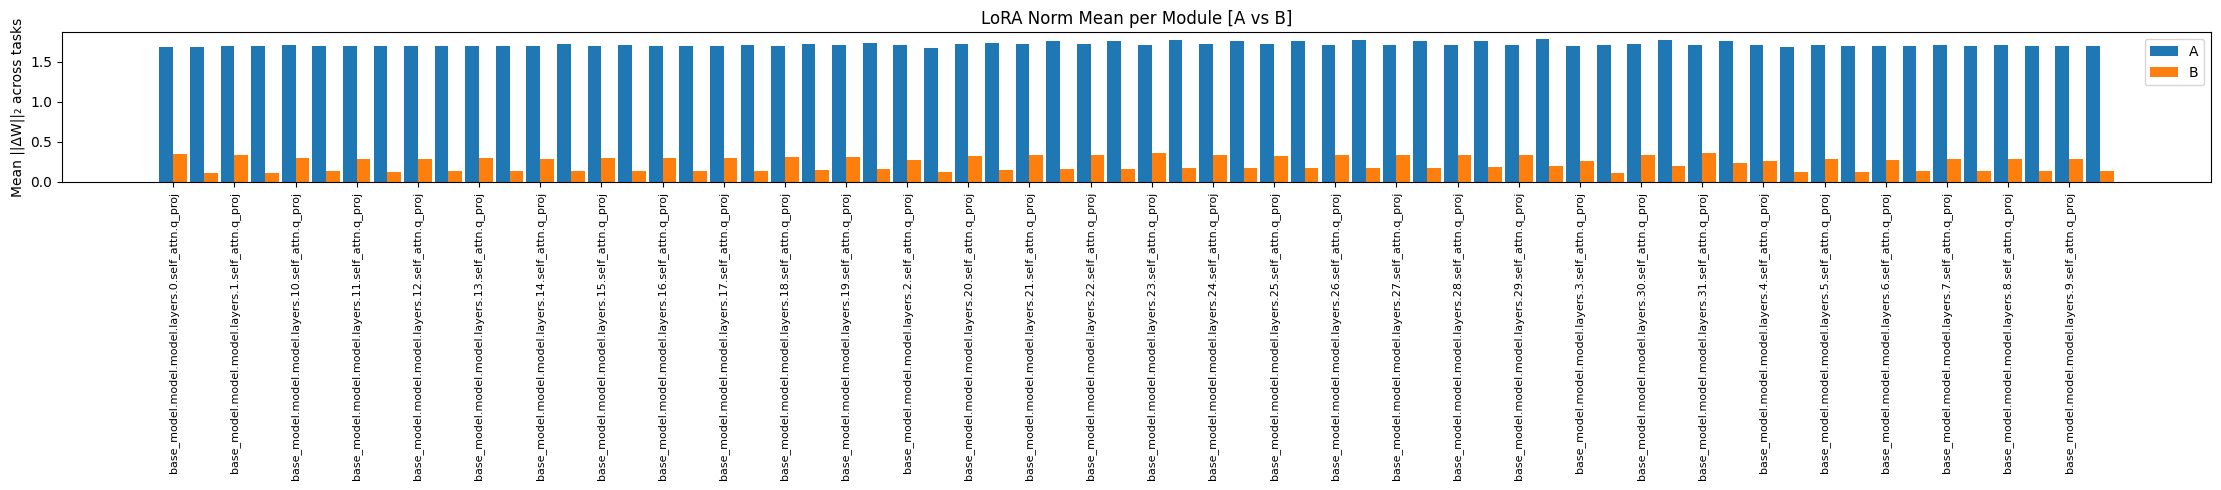

In [25]:
plot_module_norm_means_AB(tasks, filtered_bases, sort_by="avg", title_suffix="[A vs B]")

In [26]:
# ---- ΔW 벡터 생성 (모듈: base, 태스크 전체)
def module_task_vectors_dW(base, tasks):
    vecs = []
    for t in tasks:
        sd = target_loras[t]
        A = sd[base + ".lora_A.weight"].detach().cpu().float()  # [r, d_in]
        B = sd[base + ".lora_B.weight"].detach().cpu().float()  # [d_out, r]
        dW = torch.matmul(B, A).reshape(-1)                     # [d_out * d_in]
        vecs.append(dW)
    return torch.stack(vecs)  # [T, D]

# ---- 코사인 행렬/상삼각 평균/Norm
def cosine_matrix(X):  # X: [T, D]
    Xn = X / (X.norm(dim=1, keepdim=True) + 1e-12)
    return (Xn @ Xn.T)  # [T, T]

def upper_mean_excl_diag(M):  # torch.Tensor [T,T]
    T = M.shape[0]
    if T <= 1: return float("nan")
    iu = torch.triu_indices(T, T, offset=1)
    return M[iu[0], iu[1]].mean().item()

def l2_norms(X):  # X: [T, D]
    return X.norm(dim=1).cpu().numpy()

# ---- (1) 모듈별 코사인 유사도 히트맵 & Norm 막대
def plot_module_dW(base, tasks, max_label=40, outdir=None):
    X = module_task_vectors_dW(base, tasks)   # [T,D]
    C = cosine_matrix(X).cpu().numpy()
    norms = l2_norms(X)

    # Norm
    plt.figure(figsize=(max(6, min(16, len(tasks)*0.25)), 4.5))
    plt.bar(np.arange(len(tasks)), norms)
    plt.title(f"[ΔW Norm] {base}")
    if len(tasks) <= max_label:
        plt.xticks(np.arange(len(tasks)), tasks, rotation=90)
    else:
        step = math.ceil(len(tasks)/max_label)
        idx = np.arange(0, len(tasks), step)
        plt.xticks(idx, [tasks[i] for i in idx], rotation=90)
    plt.ylabel("||ΔW||₂")
    plt.tight_layout()
    if outdir:
        os.makedirs(outdir, exist_ok=True)
        p = os.path.join(outdir, f"{base.replace('/', '_')}_dW_norm.png")
        plt.savefig(p, dpi=200)
        print("Saved:", p)
    plt.show()

    # Cosine heatmap
    plt.figure(figsize=(6, 5.5))
    im = plt.imshow(C, aspect="auto", interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04, label="cosine similarity")
    plt.title(f"[ΔW Cosine] {base}")
    if len(tasks) <= 30:
        plt.xticks(np.arange(len(tasks)), tasks, rotation=90, fontsize=7)
        plt.yticks(np.arange(len(tasks)), tasks, fontsize=7)
    else:
        plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    if outdir:
        p = os.path.join(outdir, f"{base.replace('/', '_')}_dW_cosine.png")
        plt.savefig(p, dpi=200)
        print("Saved:", p)
    plt.show()

# ---- (2) 모듈별 모든 조합 평균 유사도(ΔW 기준) 막대 플롯
def compute_module_pairwise_means_dW(tasks, bases, sort_by="val"):
    mods, vals = [], []
    for base in bases:
        X = module_task_vectors_dW(base, tasks)  # [T,D]
        C = cosine_matrix(X)
        m = upper_mean_excl_diag(C)
        mods.append(base); vals.append(m)
    if sort_by:
        order = np.argsort(vals)[::-1]
        mods = [mods[i] for i in order]
        vals = [vals[i] for i in order]
    return mods, vals

def plot_module_pairwise_means_dW(tasks, bases, max_label=40, sort_by="val", title_suffix=""):
    mods, vals = compute_module_pairwise_means_dW(tasks, bases, sort_by=sort_by)
    n = len(mods); x = np.arange(n)
    plt.figure(figsize=(max(8, min(24, n*0.35)), 5))
    plt.bar(x, vals, width=0.8)
    plt.ylabel("Mean pairwise cosine (ΔW, off-diagonal)")
    plt.title(f"Pairwise Mean Similarity per Module {title_suffix}".strip())
    if n <= max_label:
        plt.xticks(x, mods, rotation=90, fontsize=8)
    else:
        step = math.ceil(n/max_label)
        idx = np.arange(0, n, step)
        plt.xticks(idx, [mods[i] for i in idx], rotation=90, fontsize=8)
    plt.tight_layout()
    plt.show()

# ---- (3) 모듈별 평균 Norm(ΔW 기준) 막대 플롯
def compute_module_norm_means_dW(tasks, bases, sort_by="val"):
    mods, means = [], []
    for base in bases:
        X = module_task_vectors_dW(base, tasks)   # [T,D]
        m = l2_norms(X).mean()
        mods.append(base); means.append(m)
    if sort_by:
        order = np.argsort(means)[::-1]
        mods = [mods[i] for i in order]
        means = [means[i] for i in order]
    return mods, means

def plot_module_norm_means_dW(tasks, bases, max_label=40, sort_by="val", title_suffix=""):
    mods, means = compute_module_norm_means_dW(tasks, bases, sort_by=sort_by)
    n = len(mods); x = np.arange(n)
    plt.figure(figsize=(max(8, min(24, n*0.35)), 5))
    plt.bar(x, means, width=0.8)
    plt.ylabel("Mean ||ΔW||₂ across tasks")
    plt.title(f"Mean ΔW Norm per Module {title_suffix}".strip())
    if n <= max_label:
        plt.xticks(x, mods, rotation=90, fontsize=8)
    else:
        step = math.ceil(n/max_label)
        idx = np.arange(0, n, step)
        plt.xticks(idx, [mods[i] for i in idx], rotation=90, fontsize=8)
    plt.tight_layout()
    plt.show()

Saved: ./lora_rel_plots_dW/base_model.model.model.layers.0.self_attn.q_proj_dW_norm.png


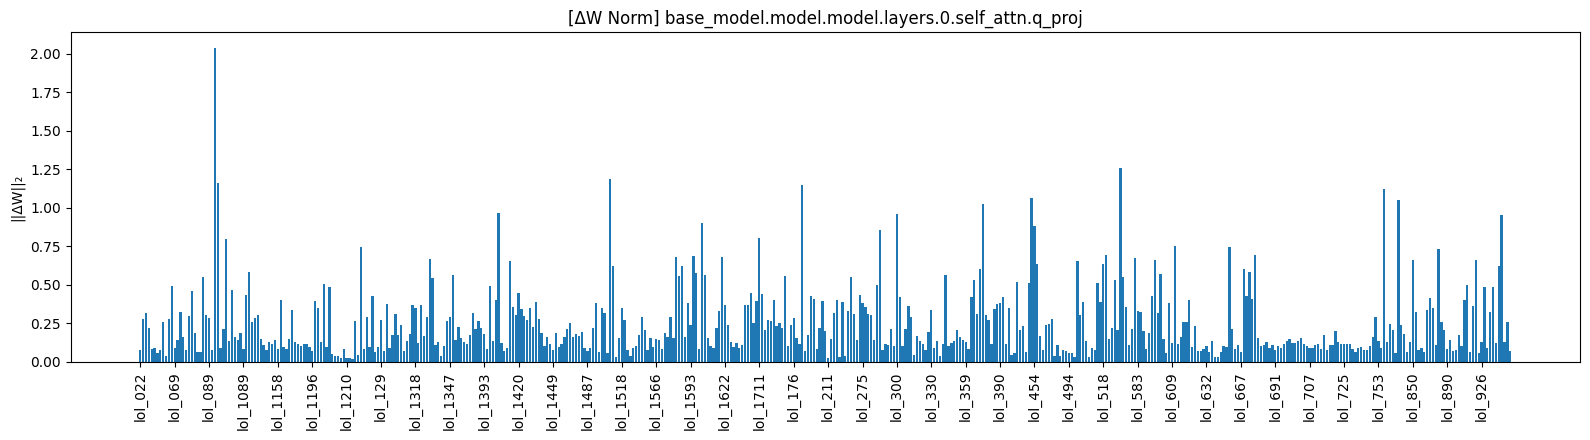

Saved: ./lora_rel_plots_dW/base_model.model.model.layers.0.self_attn.q_proj_dW_cosine.png


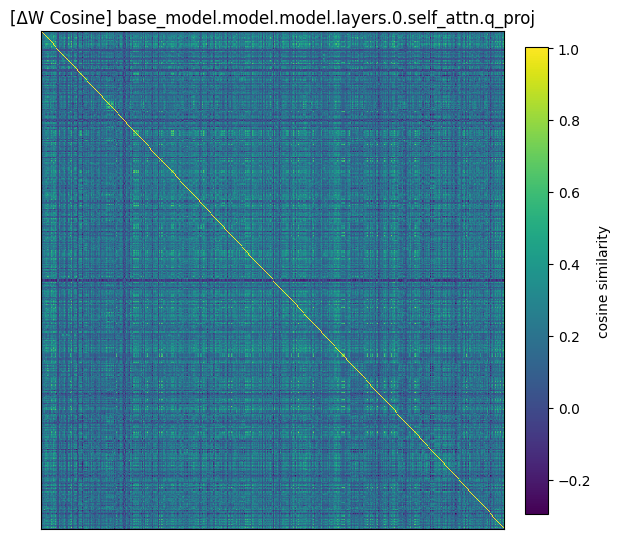

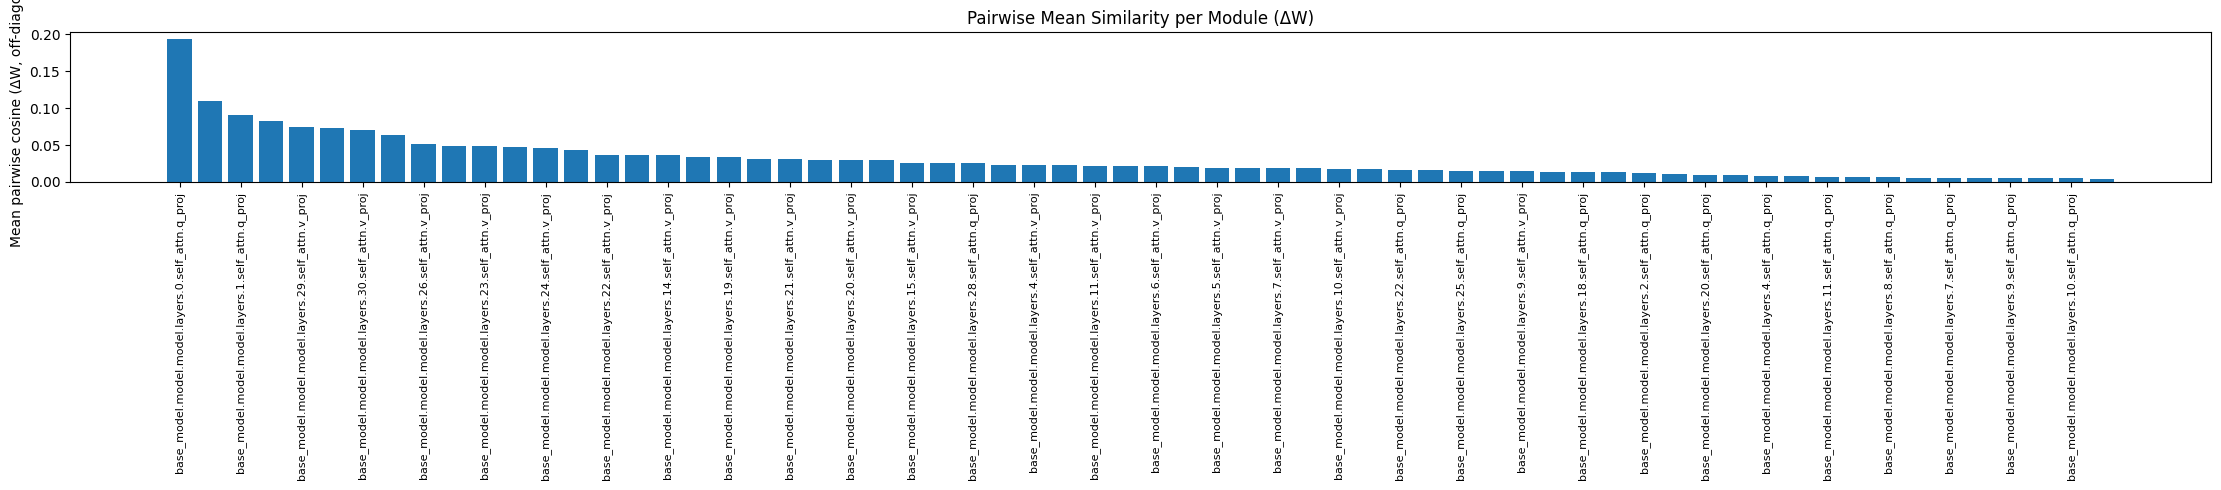

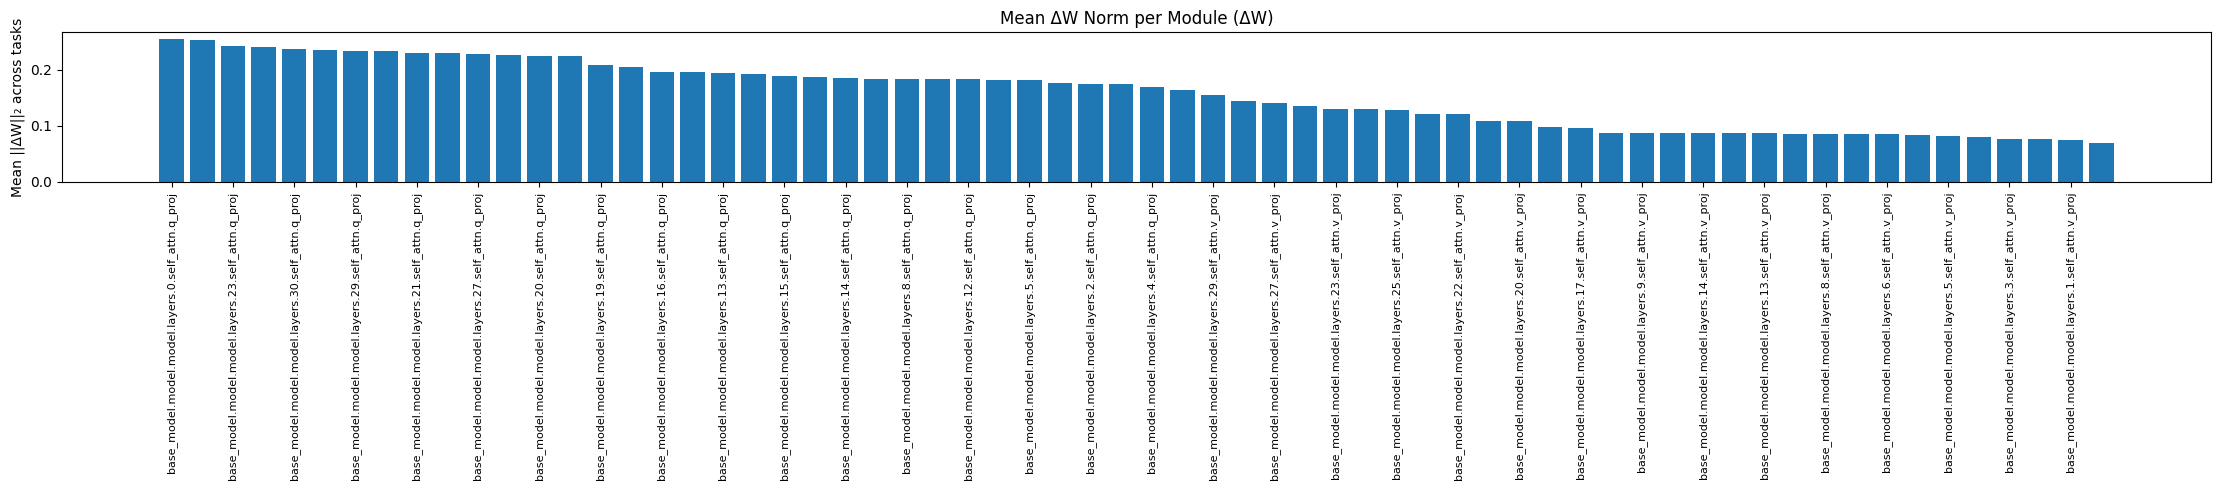

In [27]:
# 단일 모듈 확인
plot_module_dW(filtered_bases[0], tasks, outdir="./lora_rel_plots_dW")

# 모든 모듈 평균 유사도(ΔW)
plot_module_pairwise_means_dW(tasks, filtered_bases, sort_by="val", title_suffix="(ΔW)")

# 모든 모듈 평균 Norm(ΔW)
plot_module_norm_means_dW(tasks, filtered_bases, sort_by="val", title_suffix="(ΔW)")